<img src="HH_single_neuron_with_synapse.png">

In [82]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline
writer = tf.summary.FileWriter('./')

In [83]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [162]:
num_iterations = 200
num_neurons = 10

tf.reset_default_graph()

In [171]:
ve = tf.constant(-60., name='ve')

# Different parameters for different neurons
c = tf.Variable(0.01 ,dtype=tf.float32)

def fIl1(v):
    with tf.name_scope('fIl1'):
        return c*(ve-v)

def fIl2(v):
    with tf.name_scope('fIl2'):
        return c*(ve-v)

def fIl3(v):
    with tf.name_scope('fIl3'):
        return c*(ve-v)

def fIl4(v):
    with tf.name_scope('fIl4'):
        return c*(ve-v)

# Abstracting out the functions
current_functions = [fIl1, fIl2, fIl3, fIl4]

In [172]:
connections = []
weights = []
for i in range(num_neurons):
    temp_conns = []
    temp_weights = []
    for j in range(num_neurons):
        if i != j:
            number = randint(0, 99)
            if number < 5:
                temp_conns.append(j)
                temp_weights.append(5/100)
    connections.append(tf.Variable(np.asarray(temp_conns), dtype=tf.int32))
    weights.append(tf.Variable(np.asarray(temp_weights), dtype=tf.float32))

In [173]:
def fIs(v, fired):
    mul_product = []

    for i in range(num_neurons):
        gather = tf.gather(tf.multiply(v, fired), connections[i])
        mul_product.append(tf.reduce_sum(gather))    
        
    return tf.stack(mul_product, 0)

In [174]:
def call_currents(v, n, h, t, step_input):    
    dv = 0.
    
    with tf.name_scope('call_currents'):
        for fn in current_functions:
            dv += fn(v)
        
        with tf.name_scope('stack_call_currents_tensors'):
            return [dv, tf.Variable(np.array([-0.]*num_neurons), dtype=tf.float32), 
                tf.Variable(np.array([0.]*num_neurons), dtype=tf.float32)]

In [175]:
h_cons = tf.constant(0.01, name='h')
h_by_two_cons = tf.constant(0.005, name='h_by_two_cons')
one_by_six_cons = tf.constant(tf.divide(1, 6), name='one_by_six_cons')
two_cons = tf.constant(2., name='two_cons')
firing_threshold = tf.constant(1.0, name='firing_constant')

def neuron_combined_steps(prev_state, step_input):
    with tf.name_scope('unstack_prev_interation_vals'):
        v, n, h, fired, t = prev_state
    
    with tf.name_scope('RK1'):
        v_1, n_1, h_1 = call_currents(v, n, h, t, step_input)
    
        with tf.name_scope('synapse_calc_1'):
            v_1 = v_1 + fIs(v, fired)

    with tf.name_scope('RK2'):
        v_2_in = tf.add(tf.multiply(h_by_two_cons, v_1), v)
        n_2_in = tf.add(tf.multiply(h_by_two_cons, n_1), n)
        h_2_in = tf.add(tf.multiply(h_by_two_cons, h_1), h)
        t_2_in = tf.add(t, h_by_two_cons)
        v_2, n_2, h_2 = call_currents(v_2_in, n_2_in, h_2_in, t_2_in, step_input)

    with tf.name_scope('RK3'):
        v_3_in = tf.add(tf.multiply(h_by_two_cons, v_2), v)
        n_3_in = tf.add(tf.multiply(h_by_two_cons, n_2), n)
        h_3_in = tf.add(tf.multiply(h_by_two_cons, h_2), h)
        t_3_in = tf.add(t, h_by_two_cons)
        v_3, n_3, h_3 = call_currents(v_3_in, n_3_in, h_3_in, t_3_in, step_input)

    with tf.name_scope('RK4'):
        v_4_in = tf.add(tf.multiply(h, v_2), v)
        n_4_in = tf.add(tf.multiply(h, n_2), n)
        h_4_in = tf.add(tf.multiply(h, h_2), h)
        t_4_in = tf.add(t, h_cons)
        v_4, n_4, h_4 = call_currents(v_4_in, n_4_in, h_4_in, t_4_in, step_input)
    
    with tf.name_scope('calc_next_iteration_tensors'):
        v_next = tf.add(tf.multiply(one_by_six_cons, tf.add_n([v_1, tf.multiply(two_cons, v_2),
                                                               tf.multiply(two_cons, v_3), v_4])), v)
        n_next = tf.add(tf.multiply(one_by_six_cons, tf.add_n([n_1, tf.multiply(two_cons, n_2),
                                                               tf.multiply(two_cons, n_3), n_4])), n)
        h_next = tf.add(tf.multiply(one_by_six_cons, tf.add_n([h_1, tf.multiply(two_cons, h_2),
                                                               tf.multiply(two_cons, h_3), h_4])), h)
        

        fired = tf.where(tf.greater(v_next, firing_threshold), tf.ones(num_neurons), tf.zeros(num_neurons))
        
        with tf.name_scope('stack_next_iteration_tensors'):
            return [v_next, n_next, h_next, fired, t+1]

In [176]:
# inputs to the neurons
inp = 0.05
inputs = tf.Variable(np.array([[inp] + [0.]*(num_neurons-1)] * num_iterations), dtype=tf.float32, name='inputs')

# initial activations and the combined input from synaptic connections
v_initial = tf.Variable(np.array([-40.]*num_neurons), dtype=tf.float32, name='v_initial')
n_initial = tf.Variable(np.array([-40.]*num_neurons), dtype=tf.float32, name='n_initial')
h_initial = tf.Variable(np.array([-40.]*num_neurons), dtype=tf.float32, name='h_initial')
fired_initial = tf.Variable(tf.zeros(num_neurons))
t = tf.constant(0., name='t')

with tf.name_scope('stack_initial_input_tensors'):
    initial_state = [v_initial, n_initial, h_initial, fired_initial, t]

# recurrent execution. will iterate to the size of the inputs
out = tf.scan(neuron_combined_steps, inputs, initializer=initial_state)

In [177]:
%%time
# running the tensorflow graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)
    iteration_vals = sess.run(out)

CPU times: user 799 ms, sys: 120 ms, total: 919 ms
Wall time: 800 ms


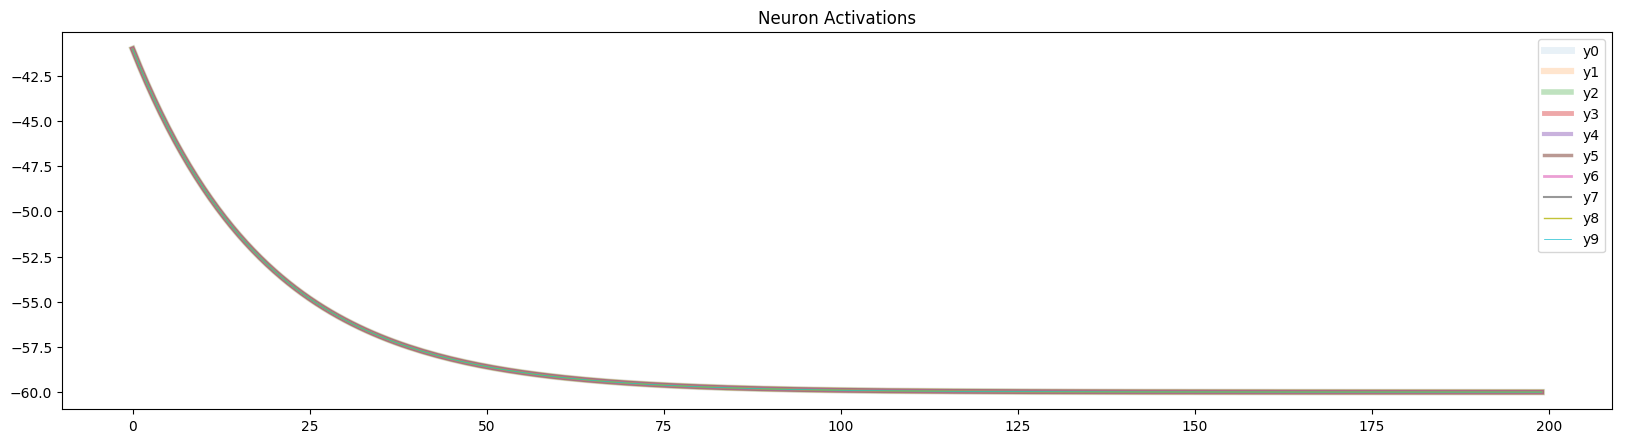

In [178]:
plt.figure(figsize=(20,5))
plt.title('Neuron Activations')
for i in range(num_neurons):
    plt.plot([y[i] for y in iteration_vals[0]], label='y'+str(i), alpha=(i+1.0)/(num_neurons),
             linewidth=5*(num_neurons-i)/(num_neurons))
plt.legend()
plt.show()

In [77]:
show_graph(tf.get_default_graph().as_graph_def())